# Imports

In [1]:
import numpy as np
import pandas as pd
np.random.seed(20030403)

In [2]:
np.random.seed(20030403)

# Activator Functions

In [3]:
def linear(x):
    """ Liniowa funkcja aktywacji """
    return  x

def sigmoidal(x):
    """ sigmoidalna funkcja aktywacji """
    return 1/(1 + np.exp(-x))

print(linear(3))
print(sigmoidal(0))

3
0.5


Działają jak należy :)

# MLP no backprop

In [4]:
class MLPNoBackprop:
    def __init__(self, layers, weights, 
                 hidden_activation_function='sigmoid', 
                 output_activation_function='linear'):
        self.layers = layers
        self.weights = weights        
        self.biases = [np.zeros((n,)) for n in layers[1:]]
        activation_functions = {"linear": linear, "sigmoid": sigmoidal}
        
        if hidden_activation_function in activation_functions:
            self.hidden_activation_function = activation_functions[hidden_activation_function]
        else:
            raise ValueError("Zla funkcja aktywacji, wybierz z:", activation_functions)
        
        if output_activation_function in activation_functions:
            self.output_activation_function = activation_functions[output_activation_function]
        else:
            raise ValueError("Zla funkcja aktywacji, wybierz z:", activation_functions)

    def forward(self, X):
        activation = X
        activations = [X]
        for i in range(len(self.weights) - 1):
            z = activation @ self.weights[i] + self.biases[i]
            activation = self.hidden_activation_function(z)
            activations.append(activation)
        z = activation @ self.weights[-1] + self.biases[-1]
        output = self.output_activation_function(z)
        activations.append(output)
        return activations

    def predict(self, X):
        return self.forward(X)[-1].flatten()
    
    def set_weights_and_biases(self, layer_idx, w, b):
        self.weights[layer_idx] = w
        self.biases[layer_idx] = b
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)


# Szkolenie dla square-simple


Moja idea szkolenie - losuje wagi i biasy dla kazdej warstwy i porownuje z najlepszym wynikiem do tej pory, jesli lepszy to zamieniam, jesli nie to szukam dalej. 

## Helper Functions

In [5]:
def drop_first_column(df): # przydatne przy wczytywaniu danych
    df.drop(df.columns[[0]], axis=1, inplace=True)

def random_weights(layers): # aby szybko losowac wagi
    return [np.random.randn(layers[i], layers[i+1]) for i in range(len(layers)-1)]

def random_biases(layers): # -||- biasy
    return [np.random.randn(n) for n in layers[1:]]

## Szkolenie - square simple

In [6]:
train_data_path = "../regression/square-simple-training.csv"
test_data_path = "../regression/square-simple-test.csv"
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
drop_first_column(train_data) # usuwam pierwsza kolumne, bo tam sa numery wierszy - niepotrzbne
drop_first_column(test_data)
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [7]:
train_data.shape

(100, 2)

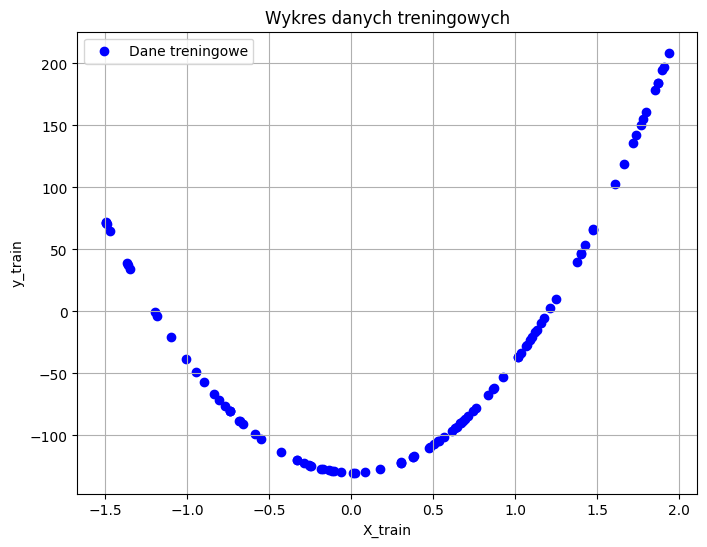

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color='blue', label='Dane treningowe')
plt.xlabel("X_train")
plt.ylabel("y_train")
plt.title("Wykres danych treningowych")
plt.legend()
plt.grid()
plt.show()

Dane wyglądają poprawnie

In [9]:
input_dim = X_train.shape[1]
variants = [ # rozpratrze 3 mozliwosci - tak jak w leonie
    [input_dim, 5, 1],       
    [input_dim, 10, 1],
    [input_dim, 5, 5, 1]
]

In [10]:
num_iterations = 10000


best_weights_list = []
best_biases_list = []
mse_res = []

for i in range(len(variants)):
    layers = variants[i]
    mlp = MLPNoBackprop(layers, random_weights(layers))
    best_mse = float('inf')
    best_weights = None
    best_biases = None

    for j in range(num_iterations):
        weights = random_weights(layers)
        biases = random_biases(layers)
        
        for m in range(len(weights)):
            mlp.set_weights_and_biases(m, weights[m], biases[m])
        
        y_pred = mlp.predict(X_train)
        mse = mlp.mse(y_train, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_weights = weights
            best_biases = biases

    for j in range(len(best_weights)):
        mlp.set_weights_and_biases(j, best_weights[j], best_biases[j])

    y_test_pred = mlp.predict(X_test)
    test_mse = mlp.mse(y_test, y_test_pred)

    print("Najlepszy MSE na zbiorze treningowym:", best_mse)
    print("MSE na zbiorze testowym:", test_mse)
    best_weights_list.append(best_weights)
    best_biases_list.append(best_biases)
    mse_res.append(test_mse)

print(mse_res)


Najlepszy MSE na zbiorze treningowym: 9665.286486387466
MSE na zbiorze testowym: 8164.478826804216
Najlepszy MSE na zbiorze treningowym: 9584.837847005827
MSE na zbiorze testowym: 8029.021823927161
Najlepszy MSE na zbiorze treningowym: 9781.279476434527
MSE na zbiorze testowym: 8282.736457377856
[np.float64(8164.478826804216), np.float64(8029.021823927161), np.float64(8282.736457377856)]


Najlepszy wynik jest dla [1, 10, 1] o wagach:

In [11]:
best_weights_list[1]

[array([[-1.42070099,  0.05823013,  0.83308292, -0.46104966, -1.27358041,
         -0.84077081,  0.53027607,  0.17931212, -0.15749933,  1.24781605]]),
 array([[ 0.32258451],
        [-2.0451704 ],
        [ 0.04319965],
        [-2.96117717],
        [-2.05785833],
        [-1.68693128],
        [-0.34615815],
        [-3.11311134],
        [-1.02052291],
        [-0.87522061]])]

i biasach

In [12]:
best_biases_list[1]

[array([ 1.45718805,  0.37886454,  0.0693731 ,  1.81779402, -0.6235552 ,
         0.17891967, -0.02668248,  1.10188527,  0.15183457,  2.1756914 ]),
 array([-0.34275031])]

# Szkolenie dla steps large

In [28]:
train_data_path = "../regression/steps-small-training.csv"
test_data_path = "../regression/steps-small-test.csv"
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
drop_first_column(train_data) # usuwam pierwsza kolumne, bo tam sa numery wierszy - niepotrzbne
drop_first_column(test_data)
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

In [29]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50, 1)
(50,)
(50, 1)
(50,)


Wykres:

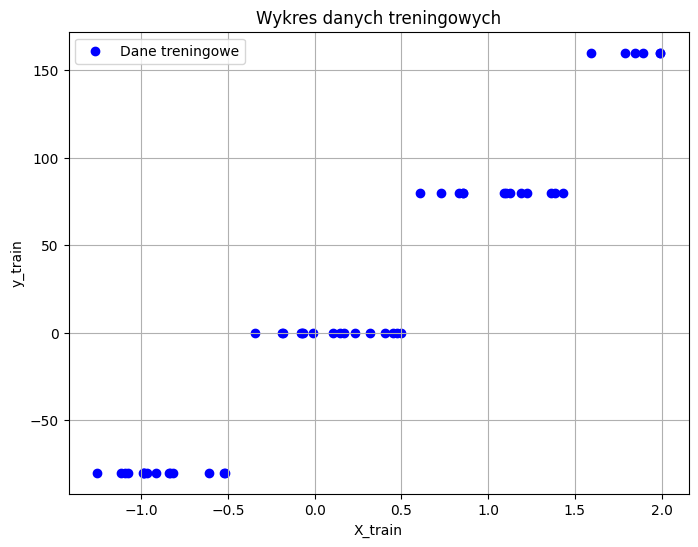

In [15]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color='blue', label='Dane treningowe')
plt.xlabel("X_train")
plt.ylabel("y_train")
plt.title("Wykres danych treningowych")
plt.legend()
plt.grid()
plt.show()


Na wykresie widac schody, sprobuje dobrac wagi tak, aby każdemu "schodkowi" przypasować neuron

In [16]:

layers = [1, 5, 1]  

W_hidden = np.array([[40,40,40,40,40]])
b_hidden = np.array([ 80, 20 ,  -20,  -60,  -80 ])

W_output = np.array([[0.0],
                     [80.0],
                     [80.0],
                     [ 80.0],
                     [ 0.0]])
b_output = np.array([-80.0])

mlp = MLPNoBackprop(
    layers=layers, 
    weights=[W_hidden, W_output],
    hidden_activation_function='sigmoid',
    output_activation_function='linear'
)

mlp.set_weights_and_biases(0, W_hidden, b_hidden)
mlp.set_weights_and_biases(1, W_output, b_output)


In [17]:
y_test_pred = mlp.predict(X_test)
test_mse = mlp.mse(y_test, y_test_pred.flatten())

print("MSE na zbiorze testowym:", test_mse)

MSE na zbiorze testowym: 7.225500591019597


zobaczmy jak wyglądają na wykresie

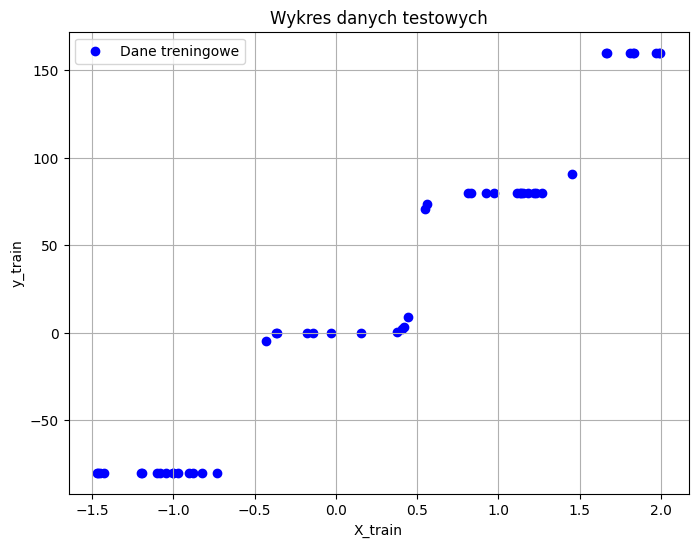

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test_pred, color='blue', label='Dane treningowe')
plt.xlabel("X_train")
plt.ylabel("y_train")
plt.title("Wykres danych testowych")
plt.legend()
plt.grid()
plt.show()


GUI

In [31]:
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

layers = [1, 5, 1]

W_hidden_init = np.array([[40, 40, 40, 40, 40]], dtype=float)
b_hidden_init = np.array([0,   0,  0,  0,  0],    dtype=float)

W_output_init = np.array([[ 0.0],
                          [40.0],
                          [40.0],
                          [40.0],
                          [40.0]], dtype=float)
b_output_init = np.array([-80.0], dtype=float)

mlp = MLPNoBackprop(
    layers=layers, 
    weights=[W_hidden_init.copy(), W_output_init.copy()],
    hidden_activation_function='sigmoid',
    output_activation_function='linear'
)
mlp.set_weights_and_biases(0, W_hidden_init.copy(), b_hidden_init.copy())
mlp.set_weights_and_biases(1, W_output_init.copy(), b_output_init.copy())

# ---------------------------------------------------------
# 4) Funkcja rysująca wykres i wypisująca MSE
#    Dodatkowo wskazuje, na jakich x neuron i jest "aktywny"
#    (tzn. sigmoid(...) >= 0.5)
# ---------------------------------------------------------
def update_plot(
    w_h0, w_h1, w_h2, w_h3, w_h4,
    b_h0, b_h1, b_h2, b_h3, b_h4,
    w_o0, w_o1, w_o2, w_o3, w_o4,
    b_o
):
    # Ustaw nowy stan wag/biasów w sieci
    W_hidden_new = np.array([[w_h0, w_h1, w_h2, w_h3, w_h4]], dtype=float)
    b_hidden_new = np.array([b_h0, b_h1, b_h2, b_h3, b_h4], dtype=float)
    
    W_output_new = np.array([[w_o0],
                             [w_o1],
                             [w_o2],
                             [w_o3],
                             [w_o4]], dtype=float)
    b_output_new = np.array([b_o], dtype=float)
    
    mlp.set_weights_and_biases(0, W_hidden_new, b_hidden_new)
    mlp.set_weights_and_biases(1, W_output_new, b_output_new)
    
    # Obliczamy predykcję na zbiorze testowym
    y_test_pred = mlp.predict(X_test)
    test_mse = mlp.mse(y_test, y_test_pred)
    
    # Rysujemy predykcję vs dane
    plt.figure(figsize=(7, 5))
    plt.scatter(X_test, y_test_pred, color='blue', label='Predykcja MLP')
    plt.scatter(X_test, y_test, color='red', marker='x', label='Dane testowe')
    
    # Dodatkowo zaznaczamy obszary, w których poszczególne neurony są "włączone" (>=0.5)
    # Liczymy to ręcznie: z_i = X_test * W_h[:, i] + b_h[i], activation = sigmoid(z_i).
    for i in range(5):
        z_i = X_test.flatten() * W_hidden_new[0, i] + b_hidden_new[i]
        act_i = 1.0 / (1.0 + np.exp(-z_i))  # sigmoid
        
        # Maska punktów, gdzie neuron i ma aktywację >= 0.5
        mask = act_i >= 0.5
        
        # Rysujemy poziomą linię (np. na wysokości -200 + i*20), żeby nie kolidowała z danymi
        y_val = -200 + i * 20
        plt.scatter(X_test[mask], np.full(np.sum(mask), y_val),
                    marker='o', label=f"Neuron {i} aktywny (>=0.5)")
    
    plt.xlabel("X_test")
    plt.ylabel("Predykcja / Dane testowe")
    plt.title(f"Wykres danych testowych\nMSE = {test_mse:.3f}")
    plt.legend()
    plt.grid(True)
    plt.show()


# ---------------------------------------------------------
# 5) Tworzymy interaktywny interfejs (16 suwaków).
#    Każdy suwak ma określony zakres (możesz go dopasować)
# ---------------------------------------------------------
slider_args = {
    'min': -80.0,
    'max':  80.0,
    'step':  1.0
}

_ = interact(
    update_plot,
    # Wagi warstwy ukrytej (5 sztuk)
    w_h0 = FloatSlider(value=W_hidden_init[0,0], description="W_h[0]", **slider_args),
    w_h1 = FloatSlider(value=W_hidden_init[0,1], description="W_h[1]", **slider_args),
    w_h2 = FloatSlider(value=W_hidden_init[0,2], description="W_h[2]", **slider_args),
    w_h3 = FloatSlider(value=W_hidden_init[0,3], description="W_h[3]", **slider_args),
    w_h4 = FloatSlider(value=W_hidden_init[0,4], description="W_h[4]", **slider_args),

    # Biasy warstwy ukrytej (5 sztuk)
    b_h0 = FloatSlider(value=b_hidden_init[0],   description="b_h[0]",  **slider_args),
    b_h1 = FloatSlider(value=b_hidden_init[1],   description="b_h[1]",  **slider_args),
    b_h2 = FloatSlider(value=b_hidden_init[2],   description="b_h[2]",  **slider_args),
    b_h3 = FloatSlider(value=b_hidden_init[3],   description="b_h[3]",  **slider_args),
    b_h4 = FloatSlider(value=b_hidden_init[4],   description="b_h[4]",  **slider_args),

    # Wagi warstwy wyjściowej (5 sztuk)
    w_o0 = FloatSlider(value=W_output_init[0,0], description="W_o[0]", **slider_args),
    w_o1 = FloatSlider(value=W_output_init[1,0], description="W_o[1]", **slider_args),
    w_o2 = FloatSlider(value=W_output_init[2,0], description="W_o[2]", **slider_args),
    w_o3 = FloatSlider(value=W_output_init[3,0], description="W_o[3]", **slider_args),
    w_o4 = FloatSlider(value=W_output_init[4,0], description="W_o[4]", **slider_args),

    # Bias warstwy wyjściowej (1 sztuka)
    b_o  = FloatSlider(value=b_output_init[0],   description="b_out", **slider_args),
);

interactive(children=(FloatSlider(value=40.0, description='W_h[0]', max=80.0, min=-80.0, step=1.0), FloatSlide…

In [20]:
y_test_pred = mlp.predict(X_test)
test_mse = mlp.mse(y_test, y_test_pred)

In [21]:
y_test.shape

(50,)

In [22]:
y_pred.shape

(100,)

In [23]:
input_dim = X_train.shape[1]
variants = [ # rozpratrze 3 mozliwosci - tak jak w leonie
    [input_dim, 5, 1],       
    [input_dim, 10, 1],
    [input_dim, 5, 5, 1]
]

In [24]:
num_iterations = 10000


best_weights_list = []
best_biases_list = []
mse_res = []

for i in range(len(variants)):
    layers = variants[i]
    mlp = MLPNoBackprop(layers, random_weights(layers))
    best_mse = float('inf')
    best_weights = None
    best_biases = None

    for j in range(num_iterations):
        weights = random_weights(layers)
        biases = random_biases(layers)
        
        for m in range(len(weights)):
            mlp.set_weights_and_biases(m, weights[m], biases[m])
        
        y_pred = mlp.predict(X_train)
        mse = mlp.mse(y_train, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_weights = weights
            best_biases = biases

    for j in range(len(best_weights)):
        mlp.set_weights_and_biases(j, best_weights[j], best_biases[j])

    y_test_pred = mlp.predict(X_test)
    test_mse = mlp.mse(y_test, y_test_pred)

    print("Najlepszy MSE na zbiorze treningowym:", best_mse)
    print("MSE na zbiorze testowym:", test_mse)
    best_weights_list.append(best_weights)
    best_biases_list.append(best_biases)
    mse_res.append(test_mse)

print(mse_res)


Najlepszy MSE na zbiorze treningowym: 6338.170327020526
MSE na zbiorze testowym: 7648.516789997786
Najlepszy MSE na zbiorze treningowym: 6213.008035047271
MSE na zbiorze testowym: 7438.3231286495875
Najlepszy MSE na zbiorze treningowym: 6428.866616795475
MSE na zbiorze testowym: 7764.53643074833
[np.float64(7648.516789997786), np.float64(7438.3231286495875), np.float64(7764.53643074833)]


Najlepszy wynik jest dla [1, 10, 1] o wagach:

In [25]:
best_biases_list[1]

[array([ 1.40747145, -0.38771906, -0.21968402,  0.36232756,  0.82798496,
         1.30302618, -1.23518659, -0.70860257,  1.70440192,  1.13931581]),
 array([1.46008532])]

In [26]:
best_weights_list[1]

[array([[ 1.72435448, -1.47680398,  1.44803117,  1.71263191,  0.07100729,
          1.99130325,  1.08491047,  0.5269872 , -0.23788748, -0.89826698]]),
 array([[ 1.72601215],
        [ 0.23748852],
        [ 0.25758541],
        [ 3.23657432],
        [ 0.730216  ],
        [ 0.7661411 ],
        [ 1.58954532],
        [-0.09306669],
        [ 0.79908632],
        [ 0.03570796]])]